
## Modello SVM per la classificazione di **categoria**

In questo notebook viene valutata una **Support Vector Machine lineare (LinearSVC)** come modello alternativo alla Logistic Regression per la classificazione testuale dei ticket.
Le SVM lineari sono ampiamente utilizzate in ambito NLP per la loro capacità di gestire spazi di feature ad alta dimensionalità e per la loro efficacia su testi brevi e sparsi.
L’obiettivo è confrontare questo approccio con la baseline logistica in termini di prestazioni e caratteristiche di interpretabilità, mantenendo invariata la struttura generale della pipeline.


In [1]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_it = stopwords.words('italian')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavezzidie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



## Caricamento del dataset preprocessato

il dataset `../data/tickets_preprocessed_split.csv` risutla già pulito e splittato nei notebook precedenti.

Contiene:
- testo grezzo (`title`, `body`) e combinato (`text`)
- testo ripulito (`text_clean`) pronto per il TF-IDF
- etichette (`category`, `priority`)
- colonna `split` che marca **train**/**test** generata in `02_preprocessing_dataset.ipynb`


In [2]:
# Carica il dataset preprocessato
df = pd.read_csv(DATA_DIR / "splits" / "tickets_preprocessed_split.csv")

# Controllo rapido delle colonne e delle prime righe
print(df.columns)
df.head()


Index(['id', 'title', 'body', 'category', 'priority', 'title_length',
       'body_length', 'text', 'text_clean', 'len_words_raw', 'len_words_clean',
       'split'],
      dtype='object')


,id,title,body,category,priority,title_length,body_length,text,text_clean,len_words_raw,len_words_clean,split
0,1,Errore stampa: impossibile stampare fattura 23...,Procedura di backup storico: export fatture an...,Amministrazione,media,69,268,Errore stampa: impossibile stampare fattura 23...,errore stampa impossibile stampare fattura 230...,48,50,train
1,2,Funzione rotta: tasto upload PDF non cliccabil...,Proposta di manutenzione ordinaria: pulizia ac...,Amministrazione,bassa,88,293,Funzione rotta: tasto upload PDF non cliccabil...,funzione rotta tasto upload pdf non cliccabile...,56,56,test
2,3,Account bloccato: utente admin_01 fermo (tropp...,err. validazione codice fiscale per nuovo clie...,Amministrazione,alta,58,257,Account bloccato: utente admin_01 fermo (tropp...,account bloccato utente admin_01 fermo troppi ...,42,46,train
3,4,Errore calcolo IVA: importo errato su fattura ...,Procedura di backup storico: export fatture an...,Amministrazione,media,107,317,Errore calcolo IVA: importo errato su fattura ...,errore calcolo iva importo errato su fattura e...,64,63,train
4,5,Blocco sistema durante elaborazione fattura 83...,Attività di background: archiviazione document...,Amministrazione,bassa,106,345,Blocco sistema durante elaborazione fattura 83...,blocco sistema durante elaborazione fattura 83...,63,65,train


In [3]:
# Verifica della colonna 'split'
df["split"].value_counts()

split
train    384
test      96
Name: count, dtype: int64


## Costruzione dei set di training e test

Separiamo feature e target usando `split`:
- `X_train` / `X_test`: testo pulito (`text_clean`)
- `y_train_cat` / `y_test_cat`: etichetta `category`
- `y_train_prio` / `y_test_prio`: etichetta `priority`

Verifichiamo dimensioni e distribuzioni per assicurarci che train e test restino comparabili.


In [4]:
# Feature testuale (già pulita)
X_train = df[df["split"] == "train"]["text_clean"]
X_test  = df[df["split"] == "test"]["text_clean"]

# Target per categoria
y_train_cat = df[df["split"] == "train"]["category"]
y_test_cat  = df[df["split"] == "test"]["category"]

# Target per priorità
y_train_prio = df[df["split"] == "train"]["priority"]
y_test_prio  = df[df["split"] == "test"]["priority"]

print("Dimensioni training:", X_train.shape[0])
print("Dimensioni test:", X_test.shape[0])

Dimensioni training: 384
Dimensioni test: 96


In [5]:
print("Distribuzione categoria - train:")
print(y_train_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione categoria - test:")
print(y_test_cat.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - train:")
print(y_train_prio.value_counts(normalize=True).round(3))

print("\nDistribuzione priorità - test:")
print(y_test_prio.value_counts(normalize=True).round(3))

Distribuzione categoria - train:
category
Tecnico            0.451
Amministrazione    0.299
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione categoria - test:
category
Tecnico            0.448
Amministrazione    0.302
Commerciale        0.250
Name: proportion, dtype: float64

Distribuzione priorità - train:
priority
media    0.383
alta     0.331
bassa    0.286
Name: proportion, dtype: float64

Distribuzione priorità - test:
priority
alta     0.354
media    0.333
bassa    0.312
Name: proportion, dtype: float64


In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)
        
    # minuscole (e togli lowercase=False dal TFIDF)
    text = text.lower()
    
    # rimuovi solo simboli non utili
    text = re.sub(r"[^\w\sàèéìòù]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [7]:
pipe_cat_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,          
        strip_accents="unicode"
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

pipe_cat_svm


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00252B51BA840>
,tokenizer,None


In [8]:
pipe_cat_svm.fit(X_train, y_train_cat)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00252B51BA840>
,tokenizer,None



### Valutazione SVM per categoria

Metriche allineate alla baseline:
- Accuracy per un colpo d'occhio generale
- F1 macro per gestire lo sbilanciamento tra classi
- Classification report con precision/recall per classe
- Matrice di confusione per individuare errori ricorrenti

In [9]:
y_pred_cat_svm = pipe_cat_svm.predict(X_test)

acc_cat_svm = accuracy_score(y_test_cat, y_pred_cat_svm)
f1_cat_svm = f1_score(y_test_cat, y_pred_cat_svm, average="macro")

print(f"Accuracy SVM (categoria): {acc_cat_svm:.3f}")
print(f"F1 macro SVM (categoria): {f1_cat_svm:.3f}")

print("\nClassification report SVM (categoria):")
print(classification_report(y_test_cat, y_pred_cat_svm))


Accuracy SVM (categoria): 0.990
F1 macro SVM (categoria): 0.987

Classification report SVM (categoria):
                 precision    recall  f1-score   support

Amministrazione       1.00      0.97      0.98        29
    Commerciale       0.96      1.00      0.98        24
        Tecnico       1.00      1.00      1.00        43

       accuracy                           0.99        96
      macro avg       0.99      0.99      0.99        96
   weighted avg       0.99      0.99      0.99        96



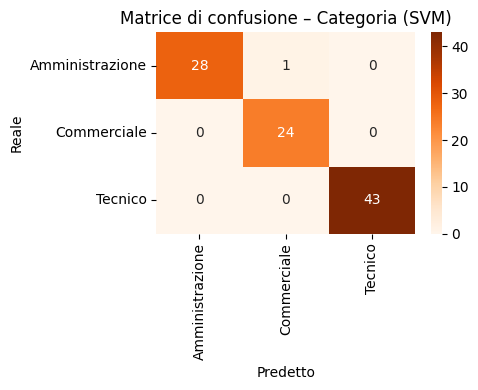

,Amministrazione,Commerciale,Tecnico
Amministrazione,28,1,0
Commerciale,0,24,0
Tecnico,0,0,43


In [10]:
labels_cat = sorted(y_train_cat.unique())

cm_cat_svm = confusion_matrix(y_test_cat, y_pred_cat_svm, labels=labels_cat)
cm_cat_svm_df = pd.DataFrame(cm_cat_svm, index=labels_cat, columns=labels_cat)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_cat_svm_df, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice di confusione – Categoria (SVM)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_cat_svm_df



## Modello SVM per la classificazione di **priorità**

Replica della pipeline usata per la categoria, cambiando solo il target su `priority`.


In [11]:
custom_weights = {"alta": 1, "media": 1, "bassa": 1.5} 

pipe_prio_svm = Pipeline([
    ("tfidf", TfidfVectorizer(        
        preprocessor=clean_text,
        stop_words=stop_it,
        lowercase=True,
        ngram_range=(1, 2),
        max_features=200,
        min_df=2,             
        max_df=0.8,
        strip_accents="unicode"
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        C=1.0,
        random_state=42
    ))
])

pipe_prio_svm


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00252B51BA840>
,tokenizer,None


In [12]:
pipe_prio_svm.fit(X_train, y_train_prio)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,<function cle...00252B51BA840>
,tokenizer,None



### Valutazione SVM per priorit?

Stesse metriche della sezione categoria:
- Accuracy
- F1 macro
- Classification report
- Matrice di confusione

Confronto immediato con la baseline logistica anche sul target `priority`.


In [13]:
y_pred_prio_svm = pipe_prio_svm.predict(X_test)

acc_prio_svm = accuracy_score(y_test_prio, y_pred_prio_svm)
f1_prio_svm = f1_score(y_test_prio, y_pred_prio_svm, average="macro")

print(f"Accuracy SVM (priorità): {acc_prio_svm:.3f}")
print(f"F1 macro SVM (priorità): {f1_prio_svm:.3f}")

print("\nClassification report SVM (priorità):")
print(classification_report(y_test_prio, y_pred_prio_svm))


Accuracy SVM (priorità): 0.802
F1 macro SVM (priorità): 0.799

Classification report SVM (priorità):
              precision    recall  f1-score   support

        alta       0.97      0.94      0.96        34
       bassa       0.73      0.73      0.73        30
       media       0.70      0.72      0.71        32

    accuracy                           0.80        96
   macro avg       0.80      0.80      0.80        96
weighted avg       0.80      0.80      0.80        96



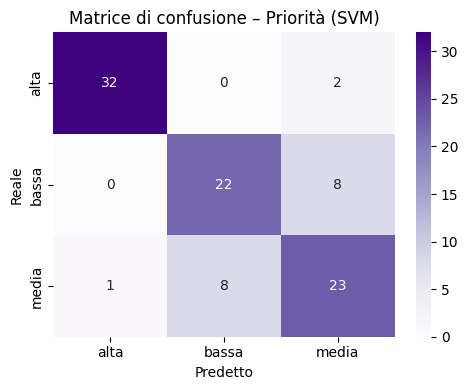

,alta,bassa,media
alta,32,0,2
bassa,0,22,8
media,1,8,23


In [14]:
labels_prio = sorted(y_train_prio.unique())

cm_prio_svm = confusion_matrix(y_test_prio, y_pred_prio_svm, labels=labels_prio)
cm_prio_svm_df = pd.DataFrame(cm_prio_svm, index=labels_prio, columns=labels_prio)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_prio_svm_df, annot=True, fmt="d", cmap="Purples")
plt.title("Matrice di confusione – Priorità (SVM)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

cm_prio_svm_df



## Feature più influenti per classe

Per rendere il modello interpretabile:
- vengono estratte le feature TF-IDF e i coefficienti del `LinearSVC`
- vengono mostrare le parole con peso maggiore per ogni classe (categoria/priorit?)
- l'output alimenta la dashboard con le *top 5 parole* associate a ciascuna etichetta


In [15]:
# Estrazione componenti dalla pipeline
vec_cat = pipe_prio_svm.named_steps["tfidf"]
clf_cat_svm = pipe_prio_svm.named_steps["clf"]

feature_names_cat = np.array(vec_cat.get_feature_names_out())
classes_cat = clf_cat_svm.classes_

top_k = 5

for idx, cls in enumerate(classes_cat):
    coefs = clf_cat_svm.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse categoria: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_cat[i]}  (peso: {coefs[i]:.3f})")



Classe categoria: alta
  urgente  (peso: 4.159)
  bloccato  (peso: 3.350)
  critico  (peso: 3.093)
  ordine urgente  (peso: 2.182)
  ordine  (peso: 1.727)

Classe categoria: bassa
  statistiche  (peso: 1.415)
  archivio  (peso: 1.242)
  campi  (peso: 1.134)
  export  (peso: 1.120)
  disponibilità  (peso: 0.995)

Classe categoria: media
  bug  (peso: 1.979)
  verificare  (peso: 1.500)
  timeout  (peso: 1.434)
  problema  (peso: 1.363)
  richiesto  (peso: 1.283)


In [16]:
vec_prio = pipe_prio_svm.named_steps["tfidf"]
clf_cat_svm = pipe_prio_svm.named_steps["clf"]

feature_names_prio = np.array(vec_prio.get_feature_names_out())
classes_prio = clf_cat_svm.classes_

top_k = 5

for idx, cls in enumerate(classes_prio):
    coefs = clf_cat_svm.coef_[idx]
    top_idx = np.argsort(coefs)[-top_k:]
    print(f"\nClasse priorità: {cls}")
    for i in reversed(top_idx):
        print(f"  {feature_names_prio[i]}  (peso: {coefs[i]:.3f})")



Classe priorità: alta
  urgente  (peso: 4.159)
  bloccato  (peso: 3.350)
  critico  (peso: 3.093)
  ordine urgente  (peso: 2.182)
  ordine  (peso: 1.727)

Classe priorità: bassa
  statistiche  (peso: 1.415)
  archivio  (peso: 1.242)
  campi  (peso: 1.134)
  export  (peso: 1.120)
  disponibilità  (peso: 0.995)

Classe priorità: media
  bug  (peso: 1.979)
  verificare  (peso: 1.500)
  timeout  (peso: 1.434)
  problema  (peso: 1.363)
  richiesto  (peso: 1.283)



## Salvataggio delle metriche SVM

i risultati vengono esportati per essere riutilizzati nel notebook di confronto e nella dashboard:
- `../data/results_baseline/results_svm.json` e `svm_metrics.json` con accuracy/F1 macro per categoria e priorità
- `../data/results_baseline/confusion_*_svm.csv` con le matrici di confusione
- `../src/app/models/*_model.joblib` con i modelli allenati per inferenza successiva


In [17]:
results_svm = {
    "categoria_accuracy": acc_cat_svm,
    "categoria_f1": f1_cat_svm,
    "priorita_accuracy": acc_prio_svm,
    "priorita_f1": f1_prio_svm
}

import json
with open(DATA_DIR / "results_baseline" / "results_svm.json", "w") as f:
    json.dump(results_svm, f)


In [18]:
import json

results_svm = {
    "categoria_accuracy": float(acc_cat_svm),
    "categoria_f1_macro": float(f1_cat_svm),
    "priorita_accuracy": float(acc_prio_svm),
    "priorita_f1_macro": float(f1_prio_svm)
}

with open(DATA_DIR / "results_baseline" / "svm_metrics.json", "w") as f:
    json.dump(results_svm, f, indent=4)


In [19]:
cm_cat_svm_df.to_csv(DATA_DIR / "results_baseline" / "confusion_cat_svm.csv", index=True)
cm_prio_svm_df.to_csv(DATA_DIR / "results_baseline" / "confusion_prio_svm.csv", index=True)

In [20]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Dopo aver allenato il modello
pipe_cat_svm.fit(X_train, y_train_cat)

# Estrai il vectorizer e il classificatore
vectorizer = pipe_cat_svm.named_steps['tfidf']
classifier = pipe_cat_svm.named_steps['clf']

# Ottieni i nomi delle feature
feature_names = np.array(vectorizer.get_feature_names_out())

# Per ogni categoria, trova le top 10 feature più discriminanti
for i, category in enumerate(classifier.classes_):
    # Coefficienti per questa classe
    coef = classifier.coef_[i]

    # Top 10 feature positive (più indicative della categoria)
    top_positive_idx = np.argsort(coef)[-10:][::-1]
    top_positive = feature_names[top_positive_idx]
    
    print(f"\n{'='*60}")
    print(f"Top keywords per {category}:")
    print(f"{'='*60}")
    for feat in top_positive:
        print(f"  - {feat}")



Top keywords per Amministrazione:
  - fatture
  - account
  - serve
  - elaborazione
  - anagrafica
  - modifica
  - ordine ord
  - risponde
  - utilizzo
  - validazione

Top keywords per Commerciale:
  - cliente
  - ricerca
  - offerta
  - contatti
  - crm
  - linea
  - suggerimento
  - colonna
  - verificare
  - inviate

Top keywords per Tecnico:
  - ordini
  - specifica
  - inviare
  - ore
  - info
  - test
  - server
  - indice
  - db
  - rischio
